<a href="https://colab.research.google.com/github/Ivelina0/Dissertation_code/blob/main/Chapter_3_Part_2_COVID_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Covid-19 Data - Cases by Specimen date


https://coronavirus.data.gov.uk/details/cases

Using the Cases by specimen date.

Importing data to google colab https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# import data with Pandas into a DataFrame: COV_all
COV_all = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data_2021-May-11 Cases by specimen date.csv')

# make the dates column into datetime data type for ease of use
COV_all['Date']= pd.to_datetime(COV_all['date'])

# Filter out all the dats for covid cases after the first date back to school 
Cov_sept = COV_all[COV_all['Date'] > pd.to_datetime('2020-09-06')]

# checking the values in column date are between 08-09-2020 and the last date in 2021
Cov_sept['Date'].sort_values(ascending=True)

244   2020-09-07
243   2020-09-08
242   2020-09-09
241   2020-09-10
240   2020-09-11
         ...    
4     2021-05-05
3     2021-05-06
2     2021-05-07
1     2021-05-08
0     2021-05-09
Name: Date, Length: 245, dtype: datetime64[ns]

# Getting the AVR COVID cases per week by the Specimen date

The new COVID cases per day by Specimen Date.

In [4]:
cases_day = Cov_sept['newCasesBySpecimenDate'].values
# We can have 35 means: n=35 x 7 array
cases_day.size

245

In [5]:
np.where(cases_day == 0)  # no 0 cases!

(array([], dtype=int64),)

In [6]:
cs_day_seven = cases_day.reshape(-1,7)

cs_day_seven.shape # have 35 means

(35, 7)

In [7]:
# take the average number of cases per week 
avr_week_cases = np.average(cs_day_seven, axis=1)
avr_week_cases

array([ 2164.57142857,  2034.28571429,  2288.42857143,  2389.28571429,
        2781.57142857,  3160.71428571,  5059.14285714,  5392.28571429,
        5540.        ,  5610.42857143,  7566.28571429, 10856.28571429,
       12195.42857143, 16943.71428571, 22926.71428571, 31355.14285714,
       41998.71428571, 53284.57142857, 56873.57142857, 38475.71428571,
       32976.71428571, 21682.71428571, 15509.28571429, 14636.71428571,
       18458.85714286, 24053.57142857, 23764.28571429, 21791.85714286,
       21867.85714286, 17595.71428571, 15785.        , 11850.42857143,
        6805.71428571,  4436.71428571,  3169.28571429])

# The parameter update functions

In [8]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

########################################
## Lambdas
########################################

def find_lambda(data, mu_init, ga_init, al_init):

  n = len(data)

  lambda_list = np.ones(n+1)

  lambda_list[0] = mu_init

  for i in range(1,n+1):
      
      lambda_k_plus_1 = (lambda_list[i-1] - mu_init)*ga_init + mu_init + al_init*data[i-1]

      lambda_list[i] = lambda_k_plus_1

  lambda_list = lambda_list.reshape(n+1,1)
    
  return lambda_list

########################################
## Mu
########################################

def find_mu(data, mu_, lambda_list):

  n = len(data)

  mu_update = (1/n)*np.sum(np.divide(mu_*data , lambda_list[:-1, :] ))
    
  return mu_update

########################################
## Alpha
########################################

def find_alpha(data, alpha_, gamma_, lambda_list):

  n = len(data)

  # starts from k=2 to k = N, so we need N-1 balues 
  A = np.zeros((n-1, 1))

  # create constants - need to start from second value k=2 (index is 1 )
  C = (data/lambda_list[:-1, :])

  # add initial value
  A[0] =  data[0]*C[1]

  for j in range(1, n-1):

    A[j] = (gamma_*(A[j-1]/C[j]) +  data[j])*C[j+1]

  D = np.sum(A*alpha_)

  # A = sum of the first N-2 data points * (1+gamma)/alpha
  A = (1 + gamma_)*np.sum(data[:-2, :])/alpha_

  B = data[-1,:]

  alpha_update = ( -B + np.sqrt(B**2 + 4*A*D) )/ (2*A)
    
  return alpha_update

########################################
## Gamma
########################################

def find_gamma(data, alpha_, gamma_, lambda_list):

  n = len(data)

  # starts from k=3 to k = N, so we need N-2 values 
  K = np.zeros((n-2, 1))

  # create constants - need to start from second value k=3 (index is 2 )
  G = (data/lambda_list[:-1, :])

  # add initial two values
  K[0] =  gamma_*data[0]*G[2]
  K[1] = ((K[0]/G[2])*2*gamma_ + gamma_*data[1])*G[3]

  # for loop the rest N-2-2 values
  for l in range(2, n-2):

    # K[2]  =((K[1]/G[3])*2*ga_init - (K[0]/G[2])*(ga_init**2) + ga_init*data1000[2])*G[4]

    K[l]  =((K[l-1]/G[l+1])*2*gamma_ - (K[l-2]/G[l])*(gamma_**2) + gamma_*data[l])*G[l+2]

  F = - np.sum(K*alpha_)

  # this one is both a and c in the quadratic eqn
  P = (alpha_/ (gamma_ + 1))* np.sum(data[:-2,:])

  gamma_update = (-P + np.sqrt(P**2 - 4*F*P))/(2*P) 
    
  return gamma_update

########################################
####### FIND ALL PARAMETERS function 
########################################

def find_param(itr, mu0, ga0, al0, data):

  n = len(data)

  iter = itr

  neg_log_likelihood = np.zeros((iter,1))

  mu_arr = np.zeros(iter)
  mu_arr[0] = mu0

  alpha_arr = np.zeros(iter)
  alpha_arr[0] = al0

  gamma_arr = np.zeros(iter)
  gamma_arr[0] = ga0

  for i in range(1,iter):
    
    # initialising the values & updating them for the loop
    mu_val = mu_arr[i-1]
    al_val = alpha_arr[i-1]
    ga_val = gamma_arr[i-1]

    # finding the lambda estimates with the parameter values 
    lambda_list = find_lambda(data, mu_val, ga_val, al_val)

    mu_arr[i] = find_mu(data, mu_val, lambda_list)

    alpha_arr[i] = find_alpha(data, al_val, ga_val, lambda_list)

    gamma_arr[i] = find_gamma(data, al_val, ga_val, lambda_list)
    
    mult_vals = np.multiply(data, np.log(lambda_list[:-1, :]))
    
    neg_log_likelihood[i] = -np.sum(mult_vals) + np.sum(lambda_list)

  return mu_arr, alpha_arr, gamma_arr, neg_log_likelihood

# Model using average cases overall as initial mu

In [9]:
# reshape into an array I can plug into the parameter updating function
avr_week_cases = avr_week_cases.reshape(-1,1)

# Set the initial mu to be the overall average cases for the 35 week period
mu_init = np.average(avr_week_cases)
mu_init

16665.18775510204

In [10]:
# Testing it for 50 iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.25, data = avr_week_cases)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract


In [11]:
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates[1:]

(array([16665.187755, 12038.364782, 10788.793820, 9865.439122, 8985.600754,
        8128.733530, 7308.021600, 6538.316484, 5830.423491, 5190.143369,
        4618.661498, 4113.458575, 3669.349993, 3279.402259, 2935.569544,
        2628.945837, 2349.506253, 2085.052882, 1818.611947, 1522.201526,
        1141.114284, 562.324902, 97.538469, 67.800917, 69.602549,
        76.023083, 86.355078, 98.724680, 108.906204, 114.937973,
        117.972040, 119.437831, 120.143016, 120.482327, 120.645624,
        120.724219, 120.762049, 120.780258, 120.789023, 120.793242,
        120.795273, 120.796250, 120.796720, 120.796947, 120.797056,
        120.797108, 120.797134, 120.797146, 120.797152, 120.797155]),
 array([0.250000, 0.263193, 0.304312, 0.351469, 0.400629, 0.449920,
        0.497879, 0.543271, 0.585117, 0.622737, 0.655730, 0.683931,
        0.707333, 0.726001, 0.739980, 0.749194, 0.753313, 0.751554,
        0.742328, 0.722489, 0.685552, 0.616180, 0.458657, 0.219035,
        0.104365, 0.049999, 

In [12]:
# Testing it for 50 iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.25, data = avr_week_cases)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract


In [13]:
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates[1:]

(array([16665.187755, 12038.364782, 10788.793820, 9865.439122, 8985.600754,
        8128.733530, 7308.021600, 6538.316484, 5830.423491, 5190.143369,
        4618.661498, 4113.458575, 3669.349993, 3279.402259, 2935.569544,
        2628.945837, 2349.506253, 2085.052882, 1818.611947, 1522.201526,
        1141.114284, 562.324902, 97.538469, 67.800917, 69.602549,
        76.023083, 86.355078, 98.724680, 108.906204, 114.937973,
        117.972040, 119.437831, 120.143016, 120.482327, 120.645624,
        120.724219, 120.762049, 120.780258, 120.789023, 120.793242,
        120.795273, 120.796250, 120.796720, 120.796947, 120.797056,
        120.797108, 120.797134, 120.797146, 120.797152, 120.797155]),
 array([0.250000, 0.263193, 0.304312, 0.351469, 0.400629, 0.449920,
        0.497879, 0.543271, 0.585117, 0.622737, 0.655730, 0.683931,
        0.707333, 0.726001, 0.739980, 0.749194, 0.753313, 0.751554,
        0.742328, 0.722489, 0.685552, 0.616180, 0.458657, 0.219035,
        0.104365, 0.049999, 

 It blows up! after 21 iterations.

In [14]:
# Testing it for 21 iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 21, mu0 = mu_init, ga0 = 0.01, al0 = 0.25, data = avr_week_cases)

In [15]:
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates[1:]

(array([16665.187755, 12038.364782, 10788.793820, 9865.439122, 8985.600754,
        8128.733530, 7308.021600, 6538.316484, 5830.423491, 5190.143369,
        4618.661498, 4113.458575, 3669.349993, 3279.402259, 2935.569544,
        2628.945837, 2349.506253, 2085.052882, 1818.611947, 1522.201526,
        1141.114284]),
 array([0.250000, 0.263193, 0.304312, 0.351469, 0.400629, 0.449920,
        0.497879, 0.543271, 0.585117, 0.622737, 0.655730, 0.683931,
        0.707333, 0.726001, 0.739980, 0.749194, 0.753313, 0.751554,
        0.742328, 0.722489, 0.685552]),
 array([0.010000, 0.010638, 0.013655, 0.017595, 0.022262, 0.027599,
        0.033576, 0.040186, 0.047463, 0.055505, 0.064501, 0.074765,
        0.086790, 0.101338, 0.119614, 0.143594, 0.176724, 0.225502,
        0.303632, 0.445126, 0.761617]),
 array([[-5120481.896714],
        [-5158661.884790],
        [-5172054.382421],
        [-5184511.572052],
        [-5196316.222071],
        [-5207181.744869],
        [-5216870.477371],
     

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [17]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


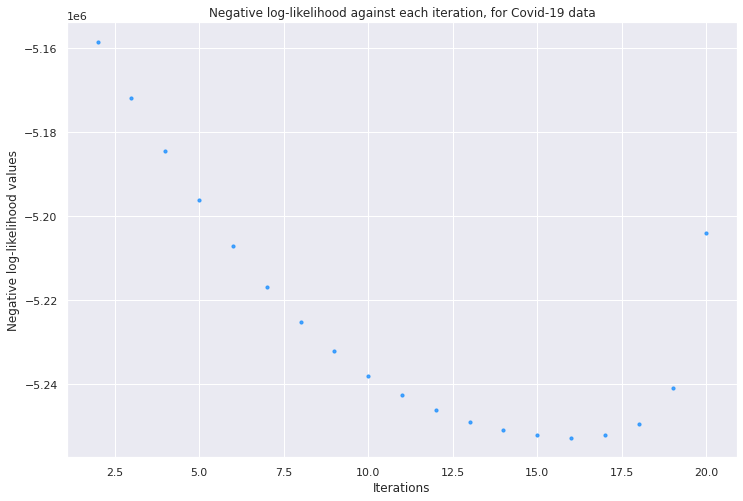

In [18]:
# Exclude the negative log-likelihood for the initial parameters.

# Setting the x-axis to be the number of iterations
x = np.arange(neg_log_likelihood_updates.shape[0])

fig = plt.figure( figsize = (12,8))

plt.scatter(x[2:], neg_log_likelihood_updates[2:], c='dodgerblue', alpha=0.8, s=10)
plt.xlabel("Iterations" ) # \n for the true parameters $ \mu = 8$, $\gamma = 0.1 $ and $ \alpha = 0.25 $ ')
plt.ylabel("Negative log-likelihood values")
plt.title("Negative log-likelihood against each iteration, for Covid-19 data")

fig.savefig("/content/gdrive/My Drive/Colab Notebooks/COVID_negative_log_likelihood.png", dpi=200,transparent=True);

In [19]:
# where is the smallest negative log-likelihood

np.where(neg_log_likelihood_updates == min(neg_log_likelihood_updates))  

(array([16]), array([0]))

In [20]:
# what are the parameters for the smallest negative log-likelihood

mu_updates[15], alpha_updates[15], gamma_updates[15], neg_log_likelihood_updates[15]

(2628.945837164436,
 0.7491943733464697,
 0.1435943148250654,
 array([-5252305.729654]))

# Generating data with these parameters

In [21]:
# Create synthetic data function

def generate_data(n, rnd_seed, mu, gamma, alpha ):

    # fixing the randomness
    np.random.seed(rnd_seed)
    
    Lambda_ = np.zeros(n+1)
    
    # First lambda(0) = mu
    Lambda_[0] = mu ## adding the first lambda_k = mu

    # Delta_n and lambda_n empty lists
    Delta_n = np.zeros(n) ## adding a dummy data point    
    
    #Generating the lambda function and synthetic data
    for i in range(0,n):

        # draw from poisson distribution
        Delta_n[i] = np.random.poisson(Lambda_[i], size=1)

        # update lambda k+1
        Lambda_[i+1] = gamma*(Lambda_[i] - mu) + mu + alpha*Delta_n[i]
    
    return Lambda_, Delta_n

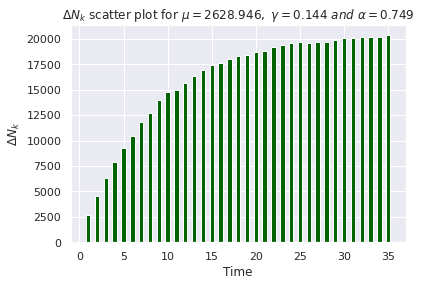

In [22]:
# Setting the no. of data points
n0 = 35
rnd_seed = 98 # random seed set

# Setting the parameters 
mu0 = mu_updates[15]
alpha0 = alpha_updates[15]
gamma0 = gamma_updates[15]

Lambda0_, Delta0_n = generate_data(n0, rnd_seed, mu0, gamma0, alpha0)

x1 = range(1,n0+1)

plt.bar(x1, Delta0_n[0:] ,  width=0.5,  color = 'darkgreen')

plt.title(r'$\Delta N_k $ scatter plot for $ \mu = {} , \ \gamma = {} \ and \ \alpha = {}  $'.format(np.round(mu0,3), np.round(gamma0,3), np.round( alpha0, 3)))
plt.xlabel('Time')
plt.ylabel('$ \Delta N_k$');

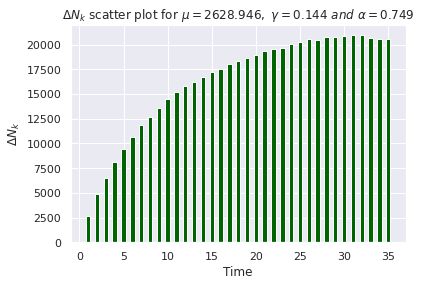

In [23]:
# Setting the no. of data points
n0 = 35
rnd_seed = 4 # random seed set to 4 

# Setting the parameters 
mu0 = mu_updates[15]
alpha0 = alpha_updates[15]
gamma0 = gamma_updates[15]

Lambda0_, Delta0_n = generate_data(n0, rnd_seed, mu0, gamma0, alpha0)

x1 = range(1,n0+1)

plt.bar(x1, Delta0_n[0:] ,  width=0.5,  color = 'darkgreen')

plt.title(r'$\Delta N_k $ scatter plot for $ \mu = {} , \ \gamma = {} \ and \ \alpha = {}  $'.format(np.round(mu0,3), np.round(gamma0,3), np.round( alpha0, 3)))
plt.xlabel('Time')
plt.ylabel('$ \Delta N_k$');

x1 = range(1,n0+1)

plt.bar(x1, Delta0_n[0:] ,  width=0.5,  color = 'darkgreen')

plt.title(r'$\Delta N_k $ scatter plot for $ \mu = {} , \ \gamma = {} \ and \ \alpha = {}  $'.format(np.round(mu0,3), np.round(gamma0,3), np.round( alpha0, 3)))
plt.xlabel('Time')
plt.ylabel('$ \Delta N_k$');

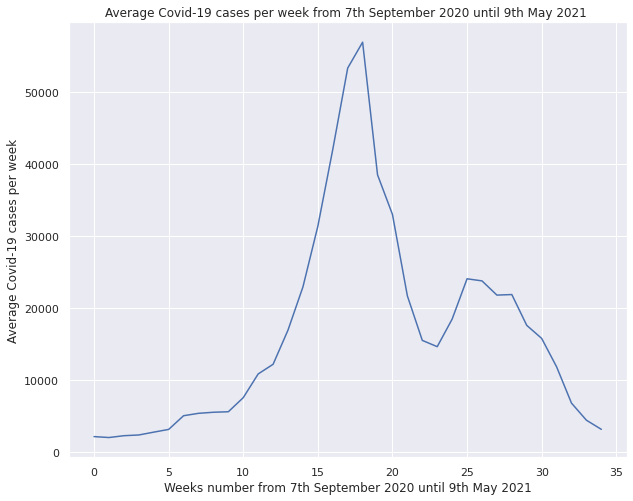

In [24]:
x2 = range(0,avr_week_cases.shape[0])

fig = plt.figure(figsize = (10,8))

plt.plot(x2, avr_week_cases) 
plt.xlabel('Weeks number from 7th September 2020 until 9th May 2021')
plt.ylabel('Average Covid-19 cases per week')

plt.title("Average Covid-19 cases per week from 7th September 2020 until 9th May 2021 ")

fig.savefig("/content/gdrive/My Drive/Colab Notebooks/COVID_avr_cases_week.png", dpi=200,transparent=True);

# More trials with different initial parameters for mu and gamma

## al0 = 0.2

In [25]:
# Testing it for 50 iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.2, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract


(nan, nan, nan, array([nan]))

## al0 = 0.3

In [26]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 100, mu0 = mu_init, ga0 = 0.01, al0 = 0.3, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract


(nan, nan, nan, array([nan]))

## al0 = 0.4

In [27]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.4, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(110.8685380087402,
 0.004586823528301321,
 946.2102061663066,
 array([49101104119213094968988207862572243436789388431134314821830976829838981861782043723927912448.000000]))

## al0 = 0.5

In [28]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.5, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1068.069551988371,
 0.9248879854423733,
 0.01925665131614252,
 array([-5261006.852452]))

## al0 = 0.6

In [29]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.6, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1066.008813392491,
 0.9366582005863121,
 0.006420102619313377,
 array([-5261340.144734]))

## al0 = 0.7

In [30]:
# Testing it for 50 iterations - even larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.7, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1062.2639739468052,
 0.939741527515488,
 0.0035077075652576338,
 array([-5261418.212704]))

## al0 = 0.8

In [31]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.8, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1059.4259614271161,
 0.9411469445119299,
 0.0022850940840279258,
 array([-5261452.018180]))

## al0 = 0.9

In [32]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.9, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1057.2070531019933,
 0.9419515323141301,
 0.0016324952473372465,
 array([-5261470.640885]))

## al0 = 1

In [33]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 1, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1055.3961284653626,
 0.9424748946610864,
 0.0012353170866331218,
 array([-5261482.351876]))

## al0 = 2

In [34]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 2, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1045.726114926441,
 0.9441318235711335,
 0.00025248382691580115,
 array([-5261515.496312]))

## al0 = 3

In [35]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 3, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1041.0529152252138,
 0.9445979127767807,
 0.0001083204774886809,
 array([-5261522.891440]))

## al0 = 5

In [36]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 5, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1036.0717930395388,
 0.9450092282713327,
 3.834427974005524e-05,
 array([-5261528.515178]))

# al0 = 1 with 500 iterations

In [40]:
# chose alpha = 3 and run for more iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 500, mu0 = mu_init, ga0 = 0.01, al0 = 1, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1039.9598657753386,
 0.9447833376722674,
 9.624423275316085e-13,
 array([-5261526.512459]))

# al0 = 0.9 with 500 iterations

In [41]:
# chose alpha = 5 and run for more iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 500, mu0 = mu_init, ga0 = 0.01, al0 = 0.9, data = avr_week_cases)
mu_updates[-1], alpha_updates[-1], gamma_updates[-1], neg_log_likelihood_updates[-1]

(1039.959865776016,
 0.944783337671879,
 1.296455727313133e-12,
 array([-5261526.512459]))

# More trials & results

Gamma init value stays the same 0.001 and mu = avr_week cases.
50 iterations

**alpha =0.6**
Neg. log. likelihood = 
-5261502.788813

**alpha =0.7**
Neg. log. likelihood = 
-5261506.496107

**alpha =0.8**
Neg. log. likelihood = 
-5261509.218173

**alpha =0.9**
Neg. log. likelihood = 
-5261511.332113

**alpha =0.99**
Neg. log. likelihood = 
-5261512.885260

**alpha = 1**
Neg. log. likelihood = 
-5261513.041912

**alpha = 1.2**
Neg. log. likelihood = 
-5261515.684910

**alpha = 2**
Neg. log. likelihood = 
-5261521.695562

**alpha = 3**
Neg. log. likelihood = 
-5261525.547421

**alpha = 5**
Neg. log. likelihood = 
-5261529.457868